In [1]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import f1_score

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import torch.optim as optim
#from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet50 import preprocess_input, decode_predictions

In [18]:
cuda =True

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
pho_path = './yelpRestaurants/train_photos'
bus_path = './yelpRestaurants/train.csv'
pho_label = 'img_biz_label.csv' 
pho_bus = './yelpRestaurants/train_photo_to_biz_ids.csv'

In [5]:
tag = {'tag': ['good_for_lunch','good_for_dinner' ,'takes_reservations','outdoor_seating',
                     'restaurant_is_expensive','has_alcohol','has_table_service','ambience_is_classy','good_for_kids']}
Yelp_Tag = pd.DataFrame(data=tag)


In [6]:
def printYelp(r):
    
    #r = [[0,1,1,0,0,1,0,1,0]]
    for i in range (9):
        if(r[0][i]):
            print('      '+Yelp_Tag['tag'][i])

In [8]:
def get_one_hot(total_label):
    labels = []
    count = 0
    for t_l in total_label:
        l = [0 for i in range(9)]
        #print(count)
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        count+=1
        labels.append(l)
    return labels

In [9]:
def F1_score(test_y,predict_y):
    tp = (test_y*predict_y).sum(axis=1)
    fp=[]
    fn=[]
    F1 = []
    for t_y,p_y in zip(test_y,predict_y):

        F1.append(f1_score(np.array(t_y), np.array(p_y), average='macro') )

    F1 = np.array(F1)
    F1_final = F1.sum()/len(F1)
    return F1,F1_final

In [10]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
input_size = 25088 ########default feature size for VGG
output = 9
class model_dnn(nn.Module):
    #####the layer should cntain the size for each layer including input and output
    #####the hidden layer should have 3 layers
    def __init__(self, dropout=0, hidden1=2048, hidden2 = 1024 , hidden3 = 256, hidden4 = 128, output=9, 
                 num_layers=1, input_size = input_size ,type_model='LSTM'):
        super(model_dnn, self).__init__()
        
        #self.word_embeddings = nn.Embedding(len(char2idx), Embedding_size)
        self.hidden1 = hidden1
        #if type_model=="LSTM":
        self.rnn=nn.LSTM(
                        input_size=input_size,
                        hidden_size=hidden1,
                        num_layers=num_layers,
                        dropout=dropout)
        self.trans = nn.Linear(input_size,hidden1)
        
        self.dense1 = nn.Linear(hidden1,hidden2)
        self.regular = nn.Linear(hidden2,hidden3)
        self.atten = nn.Linear(hidden2,hidden3)
        #self.mult = torch.mm(hidden3,hidden3)
        self.dense4 = nn.Linear(hidden3,hidden4)
        self.last = nn.Linear(hidden3,output)
        
        
        self.dense2 = nn.Linear(hidden2+hidden1,hidden3)
        self.dense3 = nn.Linear(hidden3+hidden2,output)
        
        #self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.type_model=type_model
        #self.init_hidden()
        
    def forward(self, input_feature):
        x1, new_hidden = self.rnn(input_feature)
        
        #########second layer
        x2 = self.dense1(x1)
        
        ######### multiply 
        reg = self.regular(x2)
        att = self.atten(x2)
        
        mult = torch.mul(reg,att)  ##1 X N X 256
        
        ######get sum
        sum_f = torch.sum(mult,dim=1) ##1 X 1 X 256
        #x4 = self.dense4(sum_f)
        x5 = self.last(sum_f) ##1 X 1 X 9
        return x5#,new_hidden
    
    def init_hidden(self):
        if self.type_model=="LSTM":
            self.hidden = (Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
                        ,Variable(torch.zeros(self.num_layers,1,self.hidden1)).cuda())
        else:
            self.hidden = Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
    

def var(x,option):
    ####after this the x should have 3 dimension
    x = Variable(torch.from_numpy(np.array([x]))).float()
    if cuda and option == 'keras':
        return x.cuda()
    else:
        return x

In [12]:
############transform the output from probability to one-hot vector
############define a threshold to set the label as 1 with probability higher than threshold
def get_result(output,threshold = None):
    out = []
    #print()
    if len(list(output.size())) == 1:
        ave = output.data.numpy().sum()/9
        for r in output.data.numpy():
            if r<ave:
                out.append(0)
            else:
                out.append(1)
        return np.array([out])
    
    if threshold == None:
        ####use the average of each output set
        for o in output:
            ave = o.data.numpy().sum()/9
            hot = []
            for r in o.data.numpy():
                if r<ave:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    else:
        for o in output:
            hot = []
            for r in o.data.numpy():
                if r<threshold:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    return out

In [13]:
vgg = VGG16(weights='imagenet',include_top=False)

In [14]:
def load_npy(name):
    d = np.load(str(name)+'.npy')
    return d

In [7]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [15]:
model = model_dnn(dropout=0.1, hidden1=2048, hidden2 = 1024 , hidden3 = 256,
                 num_layers=1, input_size = 25088, output = 9)
model.load_state_dict(torch.load('saved_model_1.pt'))

In [16]:
##################test the sample image
def sample_map(model,model_extractfeatures,business_id,img_num):
    #Predict labels for img_num of images in given business_id using pretrained model and feautres from model_extractfeatures
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    bus_label = np.array(get_one_hot(bus.loc[bus['business_id']==business_id]['labels']))
    
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        #print(test_img)
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        bus_feature = model_extractfeatures.predict(np.array([x]))
        bus_feature = np.reshape(bus_feature,(bus_feature.shape[0],bus_feature.shape[1]*bus_feature.shape[2]*bus_feature.shape[3]))
        result = model(var(bus_feature,'pytorch'))
        [_,F1] = F1_score(np.array(bus_label),get_result(result[0]))
        plt.imshow(x)
        plt.title('F1 score:' + str(F1))
        plt.axis('off')
        plt.show()
        print(color.BOLD +'      Business Labels:'+ color.END)
        printYelp(bus_label)
        print(color.BOLD+'      Predicted image Labels:'+color.END)
        printYelp(get_result(result[0]))

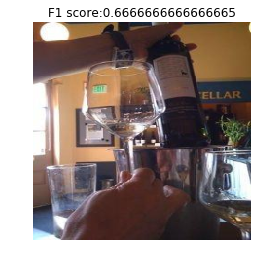

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      has_alcohol
      has_table_service
      ambience_is_classy


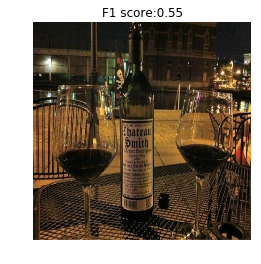

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      restaurant_is_expensive
      has_alcohol
      has_table_service
      ambience_is_classy


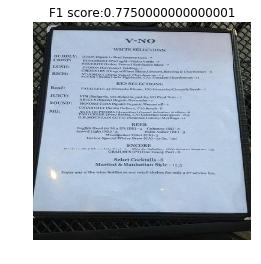

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      good_for_kids


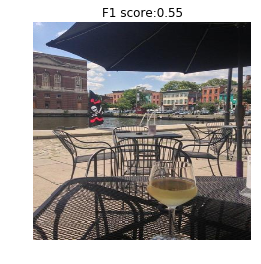

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      has_alcohol
      ambience_is_classy


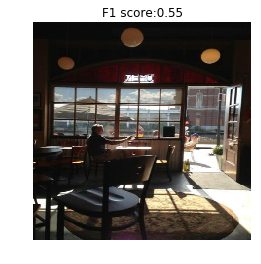

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      restaurant_is_expensive
      has_alcohol
      has_table_service
      ambience_is_classy


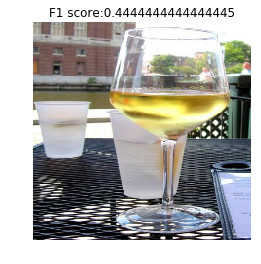

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      restaurant_is_expensive
      has_alcohol
      ambience_is_classy


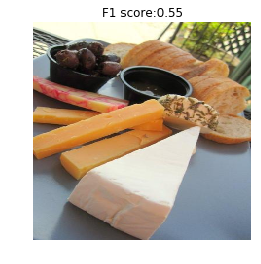

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      takes_reservations
      outdoor_seating
      has_alcohol
      good_for_kids


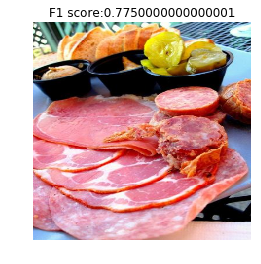

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      good_for_kids


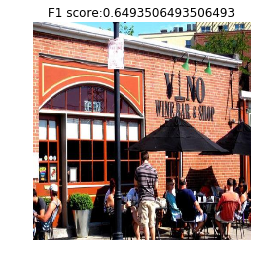

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      outdoor_seating
      has_alcohol
      good_for_kids


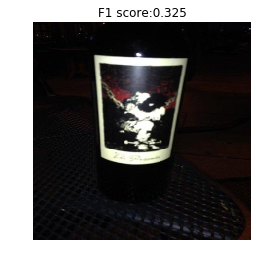

      Business Labels:
      good_for_lunch
      outdoor_seating
      has_alcohol
      has_table_service
      Predicted image Labels:
      good_for_dinner
      takes_reservations
      restaurant_is_expensive
      has_alcohol
      has_table_service
      ambience_is_classy


In [19]:
sample_map(model,vgg,131,10)